# Предсказание отмены заказа такси. Заказ может отмениться до того, как на него откликнется водитель.

In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = pd.read_csv('train_data.csv')
target = pd.read_csv('train_target.csv')

data['target'] = target

In [7]:
data.head()

,dist,due,f_class,lat,lon,s_class,t_class,target
0,5117.239228,2014-01-22 04:10:00.000,econom,55.669290,37.474336,business,NaN,0
1,3638.726690,2014-01-10 13:45:00.000,econom,55.807461,37.635045,business,NaN,0
2,15143.069693,2014-03-02 02:10:00.000,econom,55.741105,37.615821,NaN,NaN,1
3,-1.000000,2014-02-26 13:20:00.000,econom,55.625526,37.618543,NaN,NaN,1
4,4708.142572,2014-01-21 19:45:00.000,business,55.813167,37.597863,NaN,NaN,0


`dist` - расстояние, на которое сделан заказ, -1, если не указано;

`due` - дата и время заказа;

`lat` и `lon` - координаты заказа, широта и долгота;

`f_class`, `s_class`, `t_class` - параметры машины для заказа.

In [8]:
df = data.copy()

# Генерация признаков

Добавим признак - час заказа.

In [9]:
from datetime import datetime, timedelta

df["due"] = pd.to_datetime(df["due"])

In [10]:
df['hours'] = df['due'].dt.hour

In [11]:
df.head()

,dist,due,f_class,lat,lon,s_class,t_class,target,hours
0,5117.239228,2014-01-22 04:10:00,econom,55.669290,37.474336,business,NaN,0,4
1,3638.726690,2014-01-10 13:45:00,econom,55.807461,37.635045,business,NaN,0,13
2,15143.069693,2014-03-02 02:10:00,econom,55.741105,37.615821,NaN,NaN,1,2
3,-1.000000,2014-02-26 13:20:00,econom,55.625526,37.618543,NaN,NaN,1,13
4,4708.142572,2014-01-21 19:45:00,business,55.813167,37.597863,NaN,NaN,0,19


В качестве признака возьмем расстояние по долготе и широте до ближайшего из 5 городов (Воронеж, Казань, Москва, Нижний Новгород, Санкт-Петербург), в списке координаты расположены в алфавитном порядке по названию городов.

In [12]:
def dist_lat(lat):
    var = []
    city_lat = [51.661535, 55.795793, 55.755773, 56.323902, 59.938806]
    for k in city_lat:
        res = np.fabs(lat - k)
        var.append(res)
    return min(var)

In [13]:
def dist_lon(lon):
    var = []
    city_lon = [39.200287, 49.106585, 37.617761, 44.002267, 30.314278]
    for k in city_lon:
        res = np.fabs(lon - k)
        var.append(res)
    return min(var)

In [14]:
df['dist_lat'] = df['lat'].apply(dist_lat)
df['dist_lon'] = df['lon'].apply(dist_lon)

Распределим заказы по городам, то есть возьмем в качестве признака ближайший город по заказу:
Воронеж - 0, Казань - 1, Москва - 2, Нижний Новгород - 3, Санкт-Петербург - 4.

In [15]:
def distribute(x):
    var = []
    cities = [[51.661535, 39.200287], [55.795793, 49.106585], [55.755773, 37.617761],\
              [56.323902,44.002267], [59.938806,30.314278]]
    for k in cities:
        res = np.fabs(x['lat'] - k[0]) + np.fabs(x['lon'] - k[1])
        var.append(res)
    return var.index(min(var))

In [16]:
df['index_of_city'] = df.apply(distribute, axis=1)

Закодируем классы машин f_class, s_class, t_class.

In [17]:
df['s_class'] = data['s_class'].fillna('nan')
df['f_class'] = data['f_class'].fillna('nan')
df['t_class'] = data['t_class'].fillna('nan')

In [18]:
df[['f_class']] = df[['f_class']].astype('category')
df['label_f_class'] = df['f_class'].cat.codes

In [19]:
df[['s_class']] = df[['s_class']].astype('category')
df['label_s_class'] = df['s_class'].cat.codes

In [20]:
df[['t_class']] = df[['t_class']].astype('category')
df['label_t_class'] = df['t_class'].cat.codes

Отсортируем заказы по времени.

In [21]:
df.sort_values(by='due', inplace=True)

Больше всего заказов в Москве (index_of_city == 2). С помощью функции index_of_time найдем индекс заказа, который по времени позже, чем самый первый заказ, больше чем на 30 минут (заказы отсортированы по времени).

In [22]:
def index_of_time(df):
    time_vector = np.array(df['due'])
    dif_time = (time_vector - time_vector[0]).astype('timedelta64[s]')
    mask = dif_time <= timedelta(seconds=1800)
    list_mask = list(mask)
    return list_mask.index(False)

In [23]:
index = index_of_time(df[df['index_of_city']==2])

In [24]:
index

957

In [25]:
df_M = df[df['index_of_city']==2].iloc[0:957, :]

Узнаем границы, в которых меняется долгота и широта.

In [26]:
df_M.describe()

,dist,lat,lon,target,hours,dist_lat,dist_lon,index_of_city,label_f_class,label_s_class,label_t_class
count,957.000000,957.000000,957.000000,957.000000,957.0,957.000000,957.000000,957.0,957.000000,957.000000,957.000000
mean,10811.343739,55.750376,37.600832,0.260188,0.0,0.046331,0.091998,2.0,0.916405,1.406479,2.016719
std,12473.350896,0.076106,0.124131,0.438967,0.0,0.047228,0.084987,0.0,0.373428,0.954443,0.157559
min,-1.000000,55.414164,36.944159,0.000000,0.0,0.000000,0.000099,2.0,0.000000,0.000000,0.000000
25%,4464.340744,55.705765,37.528765,0.000000,0.0,0.011097,0.025512,2.0,1.000000,0.000000,2.000000
50%,9457.604403,55.754507,37.599938,0.000000,0.0,0.024060,0.061966,2.0,1.000000,2.000000,2.000000
75%,14880.087005,55.792593,37.658428,1.000000,0.0,0.077279,0.138709,2.0,1.000000,2.000000,2.000000
max,312558.997967,55.955105,38.100614,1.000000,0.0,0.341609,0.673602,2.0,3.000000,3.000000,3.000000


In [27]:
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share"
from mpl_toolkits.basemap import Basemap

In [28]:
x = df_M.loc[df_M['target']==0, 'lon'].to_list()
y = df_M.loc[df_M['target']==0, 'lat'].to_list()
x_refuse = df_M.loc[df_M['target']==1, 'lon'].to_list()
y_refuse = df_M.loc[df_M['target']==1, 'lat'].to_list()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


Text(0.5, 1.0, 'Mercator Projection')

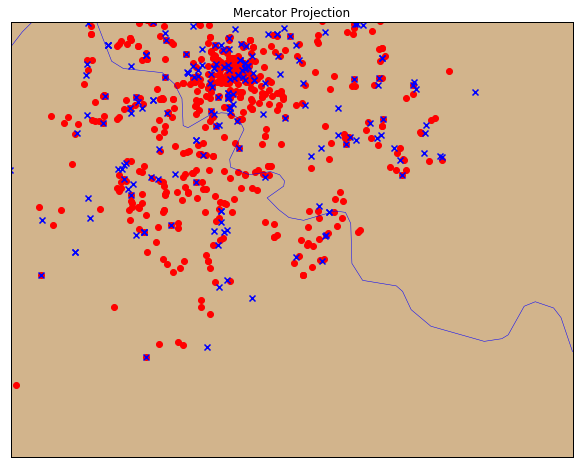

In [29]:
fig = plt.figure(num=None, figsize=(12, 8) )
m = Basemap(projection='merc',llcrnrlat=55.45,urcrnrlat=55.8,llcrnrlon=37.3,urcrnrlon=38.101,resolution='h')
m.scatter(x, y, marker = 'o', color='r', zorder=2, latlon=True)
m.scatter(x_refuse, y_refuse, marker = 'x', color='b', zorder=2, latlon=True)
m.drawcoastlines()
m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,60.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')
plt.title("Mercator Projection")

Уменьшим границы изменения долготы и широты, чтобы картинка стала крупнее.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


Text(0.5, 1.0, 'Mercator Projection')

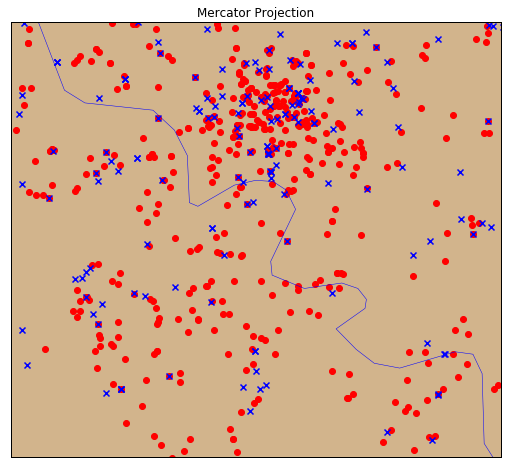

In [30]:
fig = plt.figure(num=None, figsize=(12, 8) )
m = Basemap(projection='merc',llcrnrlat=55.6,urcrnrlat=55.8,llcrnrlon=37.4,urcrnrlon=37.8,resolution='h')
m.scatter(x, y, marker = 'o', color='r', zorder=2, latlon=True)
m.scatter(x_refuse, y_refuse, marker = 'x', color='b', zorder=2, latlon=True)
m.drawcoastlines()
m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,60.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')
plt.title("Mercator Projection")

По карте видно, что есть крестики, которые накладываются на круги, поэтому в качестве признака можно взять минимальное расстояние для каждого заказа среди всех заказов, которые по времени идут после него. Предполагается, что если заказ отменят, то потом его снова сделают через некоторое время.

С помощью функции neighbourhood_time найдем индекс последнего заказа в пределах 30 минут среди последующих 100 заказов (если взять больше, то результат станет лучше, при 300 auc > 0,71). По идее надо делать для каждого города отдельно, и для Москвы больше брать заказов, чем в других городах.

In [31]:
def neighbourhood_time(df):
    time_vector = np.array(df['due'])
    index_last_time = []
    for k in range(0, df.shape[0]):
        if df.shape[0] - 1 - k <= 100:
            index_last_time.append(df.shape[0] - 1)
        else:
            dif_time = (time_vector[k + 1: k + 101]- time_vector[k]).astype('timedelta64[s]')
            mask = dif_time <= timedelta(seconds=1800)
            list_mask = list(mask)
            if np.all(list_mask) == True:
                index_last_time.append(k + 101)
            else:
                index_last_time.append(k + list_mask.index(False) + 1)
        #print(k)
    return np.array(index_last_time)

Функция min_dist находит минимальное расстояние среди 100 заказов, последующих за текущим в пределах 30 минут.

In [32]:
def min_dist(df):
    lat_vector = np.array(df['lat'])
    lon_vector = np.array(df['lon'])
    last_time = np.array(df['index_last_time'])
    min_dist = []
    for k in range(0, df.shape[0] - 1):
        if k < df.shape[0] - 1 - 100:
            if last_time[k] == k + 1:
                min_dist.append(0)
            else:
                dif_lat = lat_vector[k + 1: last_time[k]] - lat_vector[k]
                dif_lon = lon_vector[k + 1: last_time[k]] - lon_vector[k]
                dist = np.fabs(dif_lat) + np.fabs(dif_lon)
                min_dist.append(min(dist))
        else:
            dif_lat = lat_vector[k + 1:] - lat_vector[k]
            dif_lon = lon_vector[k + 1:] - lon_vector[k]
            dist = np.fabs(dif_lat) + np.fabs(dif_lon)
            min_dist.append(min(dist))
        #print(k)
    min_dist.append(0)
    return np.array(min_dist)

In [33]:
df['index_last_time'] = neighbourhood_time(df)

In [34]:
df['min_dist'] = min_dist(df)

# Построение модели

In [38]:
df_feature = ['min_dist', 'dist','dist_lat', 'dist_lon', 'label_f_class', 'label_s_class',\
              'label_t_class', 'index_of_city','hours']
df_target = ['target']

In [39]:
train_size = int(0.7 * df.shape[0])
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

In [40]:
clf = LGBMClassifier(n_estimators=50,learning_rate=0.05,num_leaves=63,max_depth=5)
clf.fit(
    df_train[df_feature], df_train[df_target].values.ravel(),
    eval_set=[(df_test[df_feature], df_test[df_target].values.ravel())],
    eval_metric='auc',
    verbose=True,
    early_stopping_rounds=50,
)

[1]	valid_0's auc: 0.652994	valid_0's binary_logloss: 0.420582
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.657627	valid_0's binary_logloss: 0.417274
[3]	valid_0's auc: 0.658377	valid_0's binary_logloss: 0.414482
[4]	valid_0's auc: 0.659272	valid_0's binary_logloss: 0.412039
[5]	valid_0's auc: 0.659855	valid_0's binary_logloss: 0.409946
[6]	valid_0's auc: 0.661097	valid_0's binary_logloss: 0.408078
[7]	valid_0's auc: 0.661214	valid_0's binary_logloss: 0.406426
[8]	valid_0's auc: 0.661985	valid_0's binary_logloss: 0.404924
[9]	valid_0's auc: 0.66354	valid_0's binary_logloss: 0.403575
[10]	valid_0's auc: 0.66586	valid_0's binary_logloss: 0.402369
[11]	valid_0's auc: 0.666974	valid_0's binary_logloss: 0.401252
[12]	valid_0's auc: 0.66773	valid_0's binary_logloss: 0.400281
[13]	valid_0's auc: 0.668673	valid_0's binary_logloss: 0.399362
[14]	valid_0's auc: 0.668873	valid_0's binary_logloss: 0.398549
[15]	valid_0's auc: 0.669033	valid_0's binary_logloss: 

[131]	valid_0's auc: 0.685841	valid_0's binary_logloss: 0.38678
[132]	valid_0's auc: 0.685874	valid_0's binary_logloss: 0.386767
[133]	valid_0's auc: 0.685887	valid_0's binary_logloss: 0.386765
[134]	valid_0's auc: 0.685883	valid_0's binary_logloss: 0.386755
[135]	valid_0's auc: 0.685903	valid_0's binary_logloss: 0.38675
[136]	valid_0's auc: 0.685962	valid_0's binary_logloss: 0.386741
[137]	valid_0's auc: 0.686032	valid_0's binary_logloss: 0.386721
[138]	valid_0's auc: 0.686064	valid_0's binary_logloss: 0.386702
[139]	valid_0's auc: 0.686052	valid_0's binary_logloss: 0.386702
[140]	valid_0's auc: 0.686058	valid_0's binary_logloss: 0.386698
[141]	valid_0's auc: 0.686075	valid_0's binary_logloss: 0.386698
[142]	valid_0's auc: 0.686067	valid_0's binary_logloss: 0.386698
[143]	valid_0's auc: 0.686099	valid_0's binary_logloss: 0.386682
[144]	valid_0's auc: 0.686106	valid_0's binary_logloss: 0.386675
[145]	valid_0's auc: 0.686099	valid_0's binary_logloss: 0.386673
[146]	valid_0's auc: 0.6861

[258]	valid_0's auc: 0.687181	valid_0's binary_logloss: 0.386137
[259]	valid_0's auc: 0.687184	valid_0's binary_logloss: 0.386132
[260]	valid_0's auc: 0.687188	valid_0's binary_logloss: 0.38613
[261]	valid_0's auc: 0.68719	valid_0's binary_logloss: 0.38613
[262]	valid_0's auc: 0.687198	valid_0's binary_logloss: 0.386128
[263]	valid_0's auc: 0.6872	valid_0's binary_logloss: 0.386125
[264]	valid_0's auc: 0.687212	valid_0's binary_logloss: 0.386122
[265]	valid_0's auc: 0.687213	valid_0's binary_logloss: 0.386119
[266]	valid_0's auc: 0.687214	valid_0's binary_logloss: 0.386119
[267]	valid_0's auc: 0.687215	valid_0's binary_logloss: 0.386119
[268]	valid_0's auc: 0.68723	valid_0's binary_logloss: 0.386113
[269]	valid_0's auc: 0.687234	valid_0's binary_logloss: 0.386113
[270]	valid_0's auc: 0.687239	valid_0's binary_logloss: 0.386113
[271]	valid_0's auc: 0.687235	valid_0's binary_logloss: 0.386108
[272]	valid_0's auc: 0.687244	valid_0's binary_logloss: 0.386104
[273]	valid_0's auc: 0.687244	v

[386]	valid_0's auc: 0.687631	valid_0's binary_logloss: 0.385923
[387]	valid_0's auc: 0.687641	valid_0's binary_logloss: 0.38592
[388]	valid_0's auc: 0.687661	valid_0's binary_logloss: 0.385915
[389]	valid_0's auc: 0.687671	valid_0's binary_logloss: 0.385911
[390]	valid_0's auc: 0.687679	valid_0's binary_logloss: 0.385906
[391]	valid_0's auc: 0.687686	valid_0's binary_logloss: 0.385904
[392]	valid_0's auc: 0.687689	valid_0's binary_logloss: 0.385903
[393]	valid_0's auc: 0.687698	valid_0's binary_logloss: 0.3859
[394]	valid_0's auc: 0.687693	valid_0's binary_logloss: 0.385902
[395]	valid_0's auc: 0.687702	valid_0's binary_logloss: 0.385899
[396]	valid_0's auc: 0.687701	valid_0's binary_logloss: 0.385898
[397]	valid_0's auc: 0.687694	valid_0's binary_logloss: 0.385899
[398]	valid_0's auc: 0.687687	valid_0's binary_logloss: 0.385902
[399]	valid_0's auc: 0.687682	valid_0's binary_logloss: 0.385902
[400]	valid_0's auc: 0.687687	valid_0's binary_logloss: 0.385901
[401]	valid_0's auc: 0.68769

[514]	valid_0's auc: 0.688259	valid_0's binary_logloss: 0.385694
[515]	valid_0's auc: 0.688265	valid_0's binary_logloss: 0.385693
[516]	valid_0's auc: 0.688281	valid_0's binary_logloss: 0.385689
[517]	valid_0's auc: 0.688282	valid_0's binary_logloss: 0.38569
[518]	valid_0's auc: 0.688283	valid_0's binary_logloss: 0.385689
[519]	valid_0's auc: 0.688305	valid_0's binary_logloss: 0.385684
[520]	valid_0's auc: 0.688316	valid_0's binary_logloss: 0.385682
[521]	valid_0's auc: 0.68832	valid_0's binary_logloss: 0.38568
[522]	valid_0's auc: 0.688315	valid_0's binary_logloss: 0.385681
[523]	valid_0's auc: 0.688329	valid_0's binary_logloss: 0.385677
[524]	valid_0's auc: 0.688337	valid_0's binary_logloss: 0.385675
[525]	valid_0's auc: 0.688339	valid_0's binary_logloss: 0.385674
[526]	valid_0's auc: 0.688335	valid_0's binary_logloss: 0.385673
[527]	valid_0's auc: 0.688332	valid_0's binary_logloss: 0.385673
[528]	valid_0's auc: 0.688331	valid_0's binary_logloss: 0.385674
[529]	valid_0's auc: 0.68831

[643]	valid_0's auc: 0.688518	valid_0's binary_logloss: 0.385556
[644]	valid_0's auc: 0.688521	valid_0's binary_logloss: 0.385555
[645]	valid_0's auc: 0.688517	valid_0's binary_logloss: 0.385557
[646]	valid_0's auc: 0.688513	valid_0's binary_logloss: 0.385556
[647]	valid_0's auc: 0.688509	valid_0's binary_logloss: 0.385557
[648]	valid_0's auc: 0.688505	valid_0's binary_logloss: 0.385558
[649]	valid_0's auc: 0.688506	valid_0's binary_logloss: 0.385558
[650]	valid_0's auc: 0.688506	valid_0's binary_logloss: 0.385558
[651]	valid_0's auc: 0.688504	valid_0's binary_logloss: 0.385559
[652]	valid_0's auc: 0.688501	valid_0's binary_logloss: 0.385558
[653]	valid_0's auc: 0.688505	valid_0's binary_logloss: 0.385558
[654]	valid_0's auc: 0.688503	valid_0's binary_logloss: 0.385558
[655]	valid_0's auc: 0.688504	valid_0's binary_logloss: 0.385559
[656]	valid_0's auc: 0.688493	valid_0's binary_logloss: 0.385562
[657]	valid_0's auc: 0.688492	valid_0's binary_logloss: 0.385563
[658]	valid_0's auc: 0.68

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1500, n_jobs=-1, num_leaves=63, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Предсказание для теста

In [41]:
test = pd.read_csv('test_data.csv')

In [42]:
test.reset_index(level=0, inplace=True)

In [43]:
test.head()

,index,dist,due,f_class,lat,lon,s_class,t_class
0,0,4611.506701,2014-03-30 11:30:00.000,econom,55.776618,37.682503,NaN,NaN
1,1,14450.067441,2014-03-06 19:10:00.000,econom,55.754659,37.810072,NaN,NaN
2,2,17755.993723,2014-03-22 13:30:00.000,business,55.726141,37.587407,NaN,NaN
3,3,8533.172059,2014-03-22 05:10:00.000,econom,55.794178,37.576456,business,NaN
4,4,-1.000000,2014-03-12 19:15:00.000,econom,55.757409,37.542186,business,NaN


In [44]:
test.sort_values(by='due', inplace=True)

In [45]:
test.head()

,index,dist,due,f_class,lat,lon,s_class,t_class
418832,418832,12228.949942,2014-03-06 08:00:00.000,econom,55.709632,37.767186,business,NaN
330723,330723,11792.691777,2014-03-06 08:00:00.000,business,55.867147,37.665435,NaN,NaN
440585,440585,1424.111651,2014-03-06 08:00:00.000,econom,55.747110,37.642815,business,NaN
462500,462500,487.808926,2014-03-06 08:00:00.000,econom,55.744936,37.615057,business,NaN
75315,75315,2503.594134,2014-03-06 08:00:00.000,econom,55.762961,37.619647,business,NaN


In [46]:
test['s_class'] = test['s_class'].fillna('nan')
test['f_class'] = test['f_class'].fillna('nan')
test['t_class'] = test['t_class'].fillna('nan')

In [47]:
test[['f_class']] = test[['f_class']].astype('category')
test['label_f_class'] = test['f_class'].cat.codes

In [48]:
test[['s_class']] = test[['s_class']].astype('category')
test['label_s_class'] = test['s_class'].cat.codes

In [49]:
test[['t_class']] = test[['t_class']].astype('category')
test['label_t_class'] = test['t_class'].cat.codes

In [50]:
test["due"] = pd.to_datetime(test["due"])

In [51]:
test['hours'] = test['due'].dt.hour

In [52]:
test['dist_lat'] = test['lat'].apply(dist_lat)
test['dist_lon'] = test['lon'].apply(dist_lon)

In [53]:
test['index_of_city'] = test.apply(distribute, axis=1)

In [54]:
test['index_last_time'] = neighbourhood_time(test)

In [55]:
test['min_dist'] = min_dist(test)

In [56]:
test.sort_values(by='index', inplace=True)

In [57]:
test.head()

,index,dist,due,f_class,lat,lon,s_class,t_class,label_f_class,label_s_class,label_t_class,hours,dist_lat,dist_lon,index_of_city,index_last_time,min_dist
0,0,4611.506701,2014-03-30 11:30:00,econom,55.776618,37.682503,nan,nan,1,2,2,11,0.019175,0.064742,2,485615,0.028971
1,1,14450.067441,2014-03-06 19:10:00,econom,55.754659,37.810072,nan,nan,1,2,2,19,0.001114,0.192311,2,9727,0.043257
2,2,17755.993723,2014-03-22 13:30:00,business,55.726141,37.587407,nan,nan,0,2,2,13,0.029632,0.030354,2,327222,0.010390
3,3,8533.172059,2014-03-22 05:10:00,econom,55.794178,37.576456,business,nan,1,0,2,5,0.001615,0.041305,2,319950,0.026150
4,4,-1.000000,2014-03-12 19:15:00,econom,55.757409,37.542186,business,nan,1,0,2,19,0.001636,0.075575,2,132386,0.013371


In [58]:
pred = clf.predict_proba(test[df_feature])

In [59]:
result=pd.DataFrame({'index':test['index'], 'target':pred[:,1]}) 
result.to_csv("res.csv", index=False)